In [1]:
from PrepareData import prepare_data
import torch
import pickle 
import wandb
import yaml
import sys
import numpy as np
import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

from architecture import CLIP
from train_utils import CombinedLoss
from train_utils import train_clip, train_total, train_recon
from train_utils import freeze_molecule_encoder, freeze_smiles_decoder, freeze_spectra_encoder
from train_utils import unfreeze_molecule_encoder, unfreeze_spectra_encoder, unfreeze_smiles_decoder


In [2]:
config = yaml.safe_load(open('./configs/standard/TEST_RUN.yaml', 'r'))

In [3]:

vocab = pickle.load(open(config['data']['vocab_path'], 'rb'))

In [4]:
dataloaders, _, _, scaler  = prepare_data(config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Normalizing each spectrum individually
Not normalizing
SMILES WILL BE RANDOMIZED


In [5]:
block = next(iter(dataloaders['train']))


In [6]:
block['IR'][0].sum()

tensor(1., dtype=torch.float64)

In [7]:
from PrepareData import id_data_map, normalize_data, combine_datasets, ParentDataset, CreateDataloaders
from dataset import Randomizer


In [8]:
smiles_id_map, ir_id_map = id_data_map(config['data']['qm9_broad_ir_path'])
new_dict_norm, scaler = normalize_data(id_ir_map=ir_id_map, type=config['data']['normalization'])
full_dataset = combine_datasets(datafiles=config['data']['datafiles'])
final_dataset = ParentDataset(clip_dataset=full_dataset,
                                max_charge=full_dataset.max_charge,
                                num_species=full_dataset.num_species,
                                smiles_id_map=smiles_id_map, 
                                ir_dict_norm=new_dict_norm, 
                                seq_len=config['data']['seq_len'],
                                vocab=vocab,
                                transform=Randomizer()
                                )


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Normalizing each spectrum individually
Not normalizing
SMILES WILL BE RANDOMIZED


In [9]:
dataloaders = CreateDataloaders(final_dataset,
                                sizes=config['data']['splits'], 
                                batch_size=27,
                                num_workers=config['data']['num_workers'],
                                shuffle=config['data']['shuffle']
                                )

In [10]:
new_dict_norm[2].sum()

1.0

In [11]:
data = next(iter(final_dataset))
print(data['IR'].sum())

tensor(1.0000, dtype=torch.float64)


In [14]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
charge_dict = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9}

def process_nist_molecule(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    # AllChem.UFFOptimizeMolecule(mol)
    num_atoms = mol.GetNumAtoms()
    conformer = mol.GetConformer()
    positions = conformer.GetPositions()
    atom_charges = [charge_dict[atom.GetSymbol()] for atom in mol.GetAtoms()]
    
    smiles_one_hot = vocab.to_seq([char for char in smi])
    
    molecule = {'num_atoms': torch.tensor(num_atoms), 
                'charges': torch.tensor(atom_charges), 
                'positions': torch.tensor(positions),
                'smiles':torch.tensor(smiles_one_hot)}
    
    
    return molecule
    

In [15]:
nist_ir_dataset = [
    ("InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C71432&Index=4&Type=IR"),
    ("InChI=1S/C2H4/c1-2/h1-2H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C74851&Index=2&Type=IR"),
    ("InChI=1S/C3H6O/c1-3(2)4/h1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C67641&Index=6&Type=IR"),
    ("InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C64175&Index=5&Type=IR"),
    ("InChI=1S/CH4O/c1-2/h2H,1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C67561&Index=4&Type=IR"),
    ("InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C67630&Index=5&Type=IR"),
    ("InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C141786&Index=4&Type=IR"),
    ("InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C71363&Index=5&Type=IR"),
    ("InChI=1S/F6S/c1-7(2,3,4,5)6", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C2551624&Index=2&Type=IR"),
    ("InChI=1S/CF4/c2-1(3,4)5", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75730&Index=3&Type=IR"),
    ("InChI=1S/CH3Br/c1-2/h1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C74839&Index=3&Type=IR"),
    ("InChI=1S/C2H3N/c1-2-3/h1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75058&Index=4&Type=IR"),
    ("InChI=1S/C2H4O/c1-2-3-1/h1-2H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75218&Index=2&Type=IR"),
    ("InChI=1S/C3H6O/c1-3-2-4-3/h3H,2H2,1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75569&Index=3&Type=IR"),
    ("InChI=1S/C4H8O/c1-3-4(2)5/h3H2,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C78933&Index=4&Type=IR"),
    ("InChI=1S/C6H14O/c1-5-7-6(2,3)4/h5H2,1-4H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C637923&Index=2&Type=IR"),
    ("InChI=1S/C4H6/c1-3-4-2/h3-4H,1-2H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C106990&Index=3&Type=IR"),
    ("InChI=1S/C3H3N/c1-2-3-4/h2H,1H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C107131&Index=3&Type=IR"),
    ("InChI=1S/C4H6O2/c1-3-6-4(2)5/h3H,1H2,2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C108054&Index=4&Type=IR"),
    ("InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C108883&Index=5&Type=IR"),
    ("InChI=1S/C5H8O2/c1-3-5(6)7-4-2/h3H,1,4H2,2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C140885&Index=4&Type=IR"),
    ("InChI=1S/C5H12O/c1-5(2,3)6-4/h1-4H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C1634044&Index=2&Type=IR"),
    ("InChI=1S/O2S/c1-3-2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C7446095&Index=3&Type=IR"),
    ("InChI=1S/C2F6/c3-1(4,5)2(6,7)8", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C76164&Index=2&Type=IR"),
    ("InChI=1S/C2HF5/c3-1(4)2(5,6)7/h1H", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C354336&Index=1&Type=IR"),
    ("InChI=1S/CHCl3/c2-1(3)4/h1H", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C67663&Index=4&Type=IR"),
    ("InChI=1S/CCl4/c2-1(3,4)5", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C56235&Index=6&Type=IR"),
    ("InChI=1S/C2Cl4/c3-1(4)2(5)6", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C127184&Index=5&Type=IR"),
    ("InChI=1S/C4H10/c1-3-4-2/h3-4H2,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C106978&Index=3&Type=IR"),
    ("InChI=1S/C2HCl3/c3-1-2(4)5/h1H", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C79016&Index=5&Type=IR"),
    ("InChI=1S/C2H3Cl3/c3-1-2(4)5/h2H,1H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C79005&Index=4&Type=IR"),
    ("InChI=1S/C8H10/c1-7-5-3-4-6-8(7)2/h3-6H,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C95476&Index=4&Type=IR"),
    ("InChI=1S/C8H10/c1-7-4-3-5-8(2)6-7/h3-6H,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C108383&Index=5&Type=IR"),
    ("InChI=1S/C8H10/c1-7-3-5-8(2)6-4-7/h3-6H,1-2H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C106423&Index=6&Type=IR"),
    ("InChI=1S/C8H10/c1-2-8-6-4-3-5-7-8/h3-7H,2H2,1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C100414&Index=5&Type=IR"),
    ("InChI=1S/C2H4Cl2/c3-1-2-4/h1-2H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C107062&Index=4&Type=IR"),
    ("InChI=1S/C2H3Cl3/c1-2(3,4)5/h1H3", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C71556&Index=4&Type=IR"),
    ("InChI=1S/CCl2F2/c2-1(3,4)5", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75718&Index=3&Type=IR"),
    ("InChI=1S/CH2Cl2/c2-1-3/h1H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75092&Index=4&Type=IR"),
    ("InChI=1S/C2H2Cl2/c1-2(3)4/h1H2", "https://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C75354&Index=4&Type=IR"),
]

In [50]:
nist_dict = pickle.load(open('../ir_data/nist_data.pkl', 'rb'))

smiles_id_map = {}



normalized_id_ir_map = {}
nist_irs = []
for key in nist_dict:
    ir = np.array(nist_dict[key]['IR'])
    ir = ir/ir.sum()
    nist_dict[key]['IR'] = ir
    nist_irs.append(ir)
    

# irs_normalized = scaler.transform(nist_irs)
irs_normalized = nist_irs
for i, key in enumerate(nist_dict):
    normalized_id_ir_map[key] = irs_normalized[i]
    inchi_key = nist_dict[key]['inchi_key']
    mol = Chem.MolFromInchi(inchi_key)
    smi = Chem.MolToSmiles(mol)
    smiles_id_map[key] = smi

In [54]:
nist_molecules = []
nist_inchi_keys = []
nist_dict = pickle.load(open('../ir_data/nist_data.pkl', 'rb'))

for idx in range(len(nist_ir_dataset)):
    inchi_key = nist_ir_dataset[idx][0]
    mol = Chem.inchi.MolFromInchi(inchi_key)
    smi = Chem.MolToSmiles(mol)
    if "S" in smi or "Cl" in smi or "Br" in smi or "I" in smi:
        continue
    molecule = process_nist_molecule(smi)
    molecule['index'] = torch.tensor(idx)
    molecule['IR'] = torch.tensor(normalized_id_ir_map[idx])   
     
    nist_molecules.append(molecule)
    nist_inchi_keys.append(inchi_key)

In [55]:
import torch.nn.functional as F


In [56]:
from torch.nn.utils.rnn import pad_sequence
props = nist_molecules[0].keys()
nist_molecules = {prop: [mol[prop] for mol in nist_molecules] for prop in props}
nist_molecules = {key: pad_sequence(val, batch_first=True) if val[0].dim() > 0 else torch.stack(val) for key, val in nist_molecules.items()}

In [57]:
for key, val in nist_molecules.items():
    print(key, val.shape)

num_atoms torch.Size([27])
charges torch.Size([27, 21])
positions torch.Size([27, 21, 3])
smiles torch.Size([27, 16])
index torch.Size([27])
IR torch.Size([27, 1801])


In [58]:
for key, val in nist_molecules.items():
    print(key, val.shape)

num_atoms torch.Size([27])
charges torch.Size([27, 21])
positions torch.Size([27, 21, 3])
smiles torch.Size([27, 16])
index torch.Size([27])
IR torch.Size([27, 1801])


In [59]:
from qm9.data.dataset import ProcessedDataset

In [60]:
nist_dataset = ProcessedDataset(nist_molecules, included_species=None, num_pts=-1, subtract_thermo=False)

In [61]:
final_nist_dataset = ParentDataset(clip_dataset=nist_dataset,
                                   smiles_id_map=smiles_id_map, 
                                   ir_dict_norm=normalized_id_ir_map, 
                                   seq_len=config['data']['seq_len'], 
                                   vocab=vocab, 
                                   transform=Randomizer(),
                                   max_charge=full_dataset.max_charge,
                                   num_species=full_dataset.num_species
                                   )

SMILES WILL BE RANDOMIZED


In [63]:
from torch.utils.data import DataLoader, Dataset
from qm9.data.collate import collate_fn
nist_dataloader = DataLoader(final_nist_dataset, batch_size=26, shuffle=False, num_workers=10, collate_fn=collate_fn)

In [64]:
for i , nist_data in enumerate(nist_dataloader):
    for key, val in sorted(nist_data.items()):
        print(key, val.shape)
    break

IR torch.Size([26, 1801])
atom_mask torch.Size([26, 21])
charges torch.Size([26, 21])
edge_mask torch.Size([11466, 1])
index torch.Size([26])
num_atoms torch.Size([26])
one_hot torch.Size([26, 21, 5])
positions torch.Size([26, 21, 3])
smiles torch.Size([26, 71])


In [77]:
config['wandb']['run_name']

'TEST_RUN_REPRODUCE_individual_norm'

In [226]:
from train_utils import load_model
num_gpus = torch.cuda.device_count()
# model = CLIP(config)
# model.to(device)
# model = torch.nn.parallel.DataParallel(model)
model = load_model('./checkpoints/TEST_RUN_REPRODUCE_individual_norm/', type="best_clip")

In [229]:
nist_dataloader = DataLoader(final_nist_dataset, batch_size=26, shuffle=True, num_workers=10, collate_fn=collate_fn)

In [230]:
for i, data in enumerate(nist_dataloader):
    data = {k: v.to(device) for k, v in data.items()}
    mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
    break

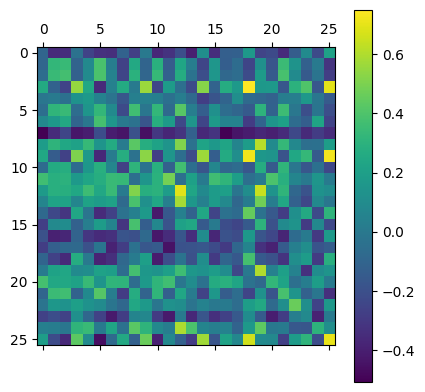

In [231]:
import matplotlib.pyplot as plt
prod = mol_latents @ spec_latents.T
%matplotlib inline
plt.matshow(prod.cpu().detach().numpy())
plt.colorbar()

In [232]:
mat = prod.cpu().detach().numpy()
diagonal_elements = np.diag(mat)
non_diagonal_elements = mat.flatten()

In [243]:
prod = mol_latents @ spec_latents.T

NUM_COLUMNS = 5
grid = []
for i in range(len(data['index'])):
    index = data['index'][i].item()
    row = prod[i]
    # get top k hits
    cur_mol = Chem.MolFromInchi(nist_dict[index]['inchi_key'])
    cur_smi = Chem.MolToSmiles(cur_mol)
    
    
    
    topk_values, topk_indices = torch.topk(row, len(row))
    
    # to print mols with only top_k matches
    if index  == data['index'][topk_indices[3].item()].item():
        pass
    else:
        continue
    
    count = 0
    
    grid.append(cur_mol)
    for value, ind in zip(topk_values, topk_indices):
        
        mol = Chem.MolFromInchi(nist_dict[data['index'][ind].item()]['inchi_key'])
        smi = Chem.MolToSmiles(mol)
       
        grid.append(mol)
        count += 1 
        if count == NUM_COLUMNS:
            break
        

In [244]:
len(grid)

36

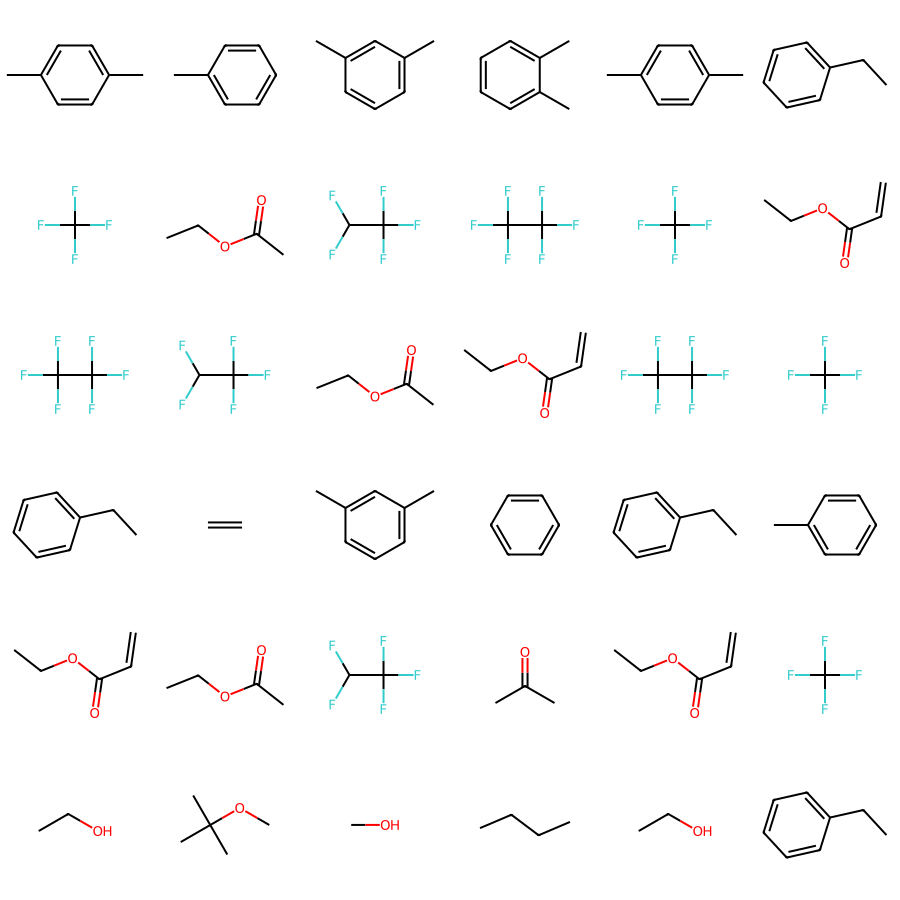

In [245]:
# plot rdkit grid 
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(grid, molsPerRow=NUM_COLUMNS+1, maxMols=len(grid), subImgSize=(150,150))
img

In [121]:
spec_latents.shape

torch.Size([26, 512])

In [122]:
import torch
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4

class BeamSampler():
    def __init__(self, model, vocab, beam_size=5):
        self.model = model
        self.vocab = vocab
        self.max_len = 40
        self.beam_size = beam_size

    def sample(self, embed, greedy_decode=False):
        embed = embed.unsqueeze(0).to(device) # shape (1, 512) 
        self.model.eval()
        sample_tensor = torch.zeros((1,self.max_len), dtype=torch.int64).to(device)
        sample_tensor[0,0] = SOS
        beams = [(sample_tensor, 0.0)]

        for i in range(self.max_len -1):
            
            new_beams = []
            for beam in beams:
                
                vec, score = beam[0], beam[1]
                tensor = vec[:,:i+1]
                logits = self.model.forward(embed, tensor)[:,-1,:]
                probabilities = F.log_softmax(logits, dim=1)
                topk_values, topk_indices = torch.topk(probabilities, self.beam_size, dim=-1)
                for value, ind in zip(topk_values[0], topk_indices[0]):
                    new_vec = vec.clone()
                    new_vec[0,i+1] = ind
                    new_score = score + value
                    new_beams.append((new_vec, new_score))     
     
            beams = sorted(new_beams, key=lambda x:x[1].item(), reverse=True)[:self.beam_size]
      
        sampled_smiles = [] 
        for beam in beams:
            smiles = ""
            chars = self.vocab.from_seq(beam[0][0])
            for char in chars:
                if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                    smiles += char
            sampled_smiles.append(smiles)
                
        return sampled_smiles
        

In [46]:
BEAM_SIZE=5
sampler = BeamSampler(model.module.smiles_decoder, model.module.vocab, beam_size=BEAM_SIZE)

In [47]:
grid = []
for i in range(len(data['index'])):
    spec = spec_latents[i]
    index = data['index'][i]
    cur_mol = Chem.MolFromInchi(nist_dict[index.item()]['inchi_key'])
    samples = sampler.sample(spec)
    grid.append(cur_mol)
    for sample in samples:
        mol = Chem.MolFromSmiles(sample)
        grid.append(mol)
    


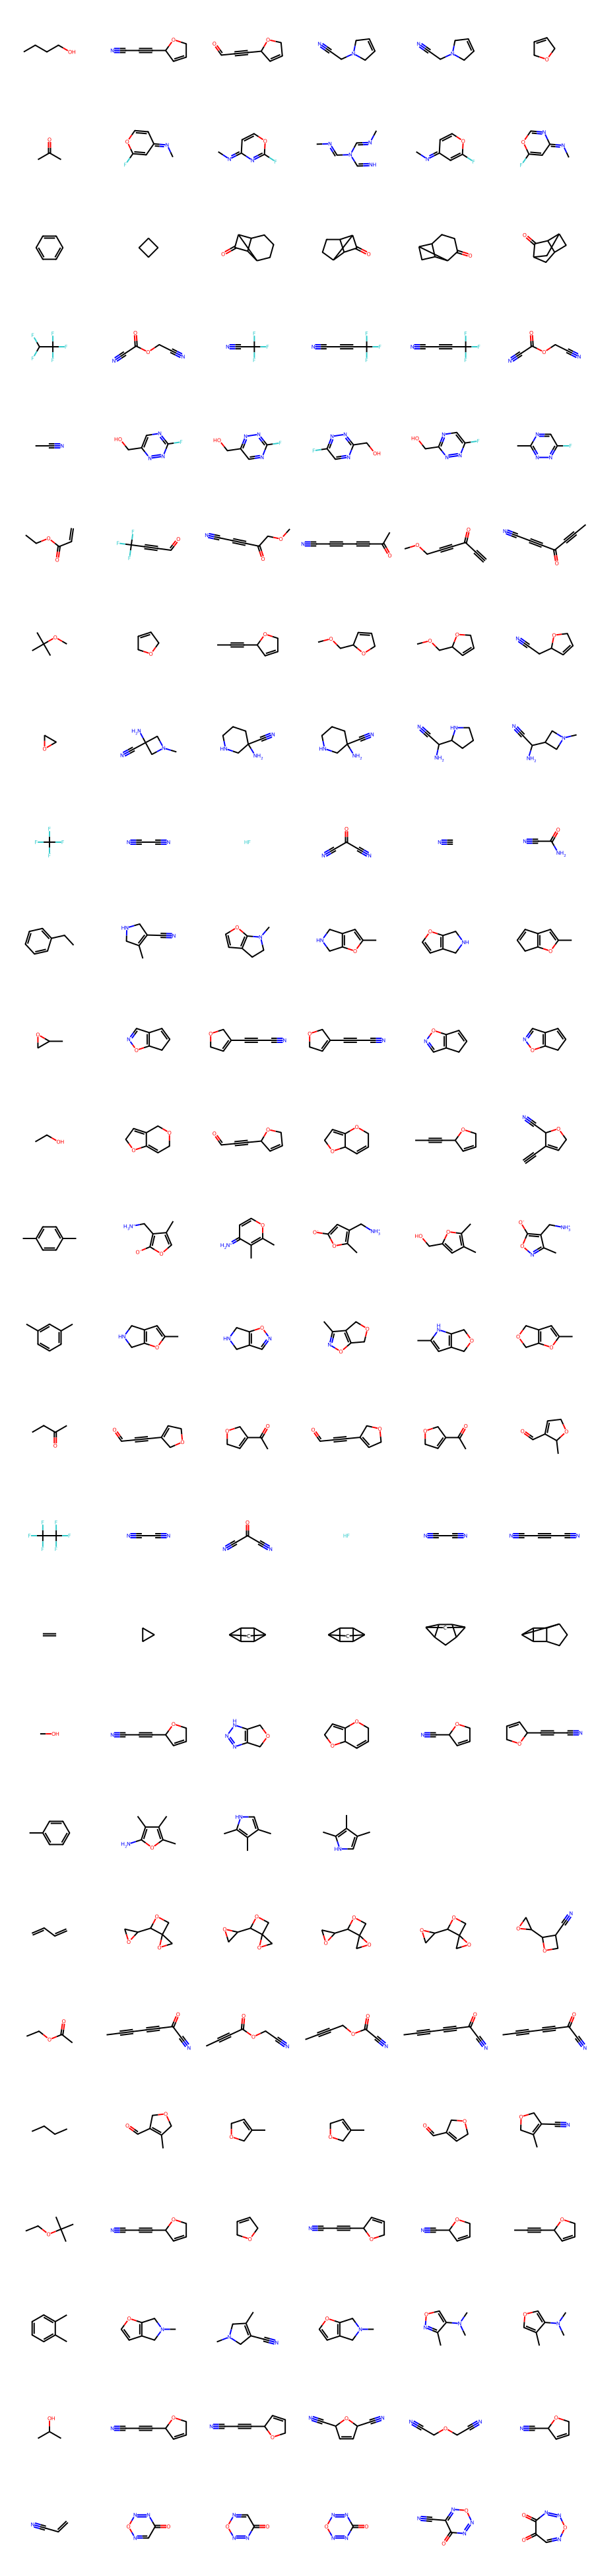

In [48]:
img = Draw.MolsToGridImage(grid, molsPerRow=BEAM_SIZE+1, maxMols=len(grid), subImgSize=(150,150))
img